# Parse Sun-Photometer V 1.1

Here I calibrate cameras using the sunphotometer according to the talk I had with Yoav.

In [122]:
from __future__ import division
%matplotlib inline
import CameraNetwork
from CameraNetwork.sunphotometer import calcAlmucantarPrinciplePlanes
from CameraNetwork.sunphotometer import parseSunPhotoMeter
from CameraNetwork.sunphotometer import readSunPhotoMeter
from CameraNetwork.sunphotometer import findClosestImageTime
from CameraNetwork.sunphotometer import sampleImage
import cPickle
import cv2
import datetime
from dateutil import parser
import ephem
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm_notebook, trange, tqdm
idx = pd.IndexSlice

## Parse the sunphotometer data

In [111]:
SUNPHOTOMETER_WAVELENGTHS = (0.4405, 0.5000, 0.6744)
df = parseSunPhotoMeter(r'../../data/aeronet/2017_09/170901_170930_Technion_Haifa_IL.alm')
date = '2017-09-07'
spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]

## Read the Quantom Efficiencies Files

In [113]:
base_path = r"../../data/camera_QE"
QEs = [
    pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-red auto.csv"), names=["wavelength", "QE"]),
    pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-green auto.csv"), names=["wavelength", "QE"]),
    pd.read_csv(os.path.join(base_path, "UI-1551LE-C_QE-blue auto.csv"), names=["wavelength", "QE"]),
]

## Connect to the cameras offline

Note that at the checked date camera 123 was on the roof.

In [175]:
cams = CameraNetwork.CLIclient()
proxy_params = CameraNetwork.retrieve_proxy_parameters()
cams.start(proxy_params)

In [176]:
camera_id = '123'
camera_df = cams.query(camera_id, date)[0]

## Fit a model to specific time

In [52]:
def integrate_QE_SP(SPM_df, QE):
    """Caclulate the argument:
        \int_{\lambda} \mathrm{QE}_{\lambda} \, \lambda \, L^{\mathrm{S-P}}_{\lambda} \, d{\lambda}
    
    This integral is calculated for each almacuntar angle (for specfic day time).
    """
    start, end = 0.4, 0.7
    dlambda = 0.005
    xspl = np.linspace(start, end, int((end - start) / dlambda))

    interp = []
    for angle, row, in SPM_df.iterrows():
        sp_vals = row.values
        isp = InterpolatedUnivariateSpline(SUNPHOTOMETER_WAVELENGTHS, sp_vals, k=2)
        sp_ipol = isp(xspl)
        
        QEp = InterpolatedUnivariateSpline(QE["wavelength"].values/1000, QE["QE"]/100)
        QE_ipol = QEp(xspl)
        
        interp.append(np.trapz(QE_ipol * sp_ipol, xspl))
        
    return SPM_df.index.values, interp

In [194]:
def sampleData(spm_dfs, QEs, ch_index, time_index, camera_df, cam_id='123', resolution=301):
    """Samples almucantar values of some camera at specific time and color channel.
    
    Args:
        spm_dfs (list of DataFrames): Sunphotometer readings (one for each visible
            in the order BGR).
        QEs (list of DataFrames): Quantum Efficiency graphs of the camera in RGB order.
        ch_index (int): Color channel to process
        time_index (int): Time index for the spm dataframes.
        camera_df (DataFrame): DataFrames of images captured for the specific day.
        cam_id (str): The camera to read from.
        resoluiton (int): The resolution in which to sample the image.

    Returns:
        angles, values, almucantar_samples, img, closest_time: Almacuntar angles,
            sunphotometer values, image values measured at the spm angles, etc. 
    """
    
    #
    # Read the SunPhotometer values at specific time.
    #
    angles_blue, values_blue = readSunPhotoMeter(spm_dfs[0], spm_dfs[0].index[time_index])
    angles_green, values_green = readSunPhotoMeter(spm_dfs[1], spm_dfs[1].index[time_index])
    angles_red, values_red = readSunPhotoMeter(spm_dfs[2], spm_dfs[2].index[time_index])
    
    #
    # Join all datasets. This is important as not all datasets are sampled
    # at all angles. Therefore I use dropna() at the end.
    #
    blue_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[0]: values_blue}, index=angles_blue)
    green_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[1]: values_green}, index=angles_green)
    red_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[2]: values_red}, index=angles_red)
    SPM_df = pd.concat((blue_df, green_df, red_df), axis=1).dropna()

    angles, values = integrate_QE_SP(SPM_df, QEs[ch_index])

    #
    # Get the closest image time.
    #
    t = spm_dfs[ch_index].index[time_index]
    closest_time = findClosestImageTime(camera_df, t, hdr='2')
    img, img_data = cams.seek(
        server_id=cam_id,
        seek_time=closest_time,
        hdr_index=-1,
        jpeg=False,
        resolution=resolution,
        correct_radiometric=False
    )
    img = img[0]
    img_data = img_data[0]
    
    almucantar_samples, almucantar_angles, almucantar_coords, \
           _, _, _ = sampleImage(img, img_data, almucantar_angles=angles)
        
    #
    # Visualize the sampling positions on the image.
    #
    for x, y in zip(almucantar_coords[0], almucantar_coords[1]):
        cv2.circle(img, (int(x), int(y)), 2, (255, 255, 0))

    return angles, values, almucantar_samples, img, closest_time, img_data

### Visualize one time.

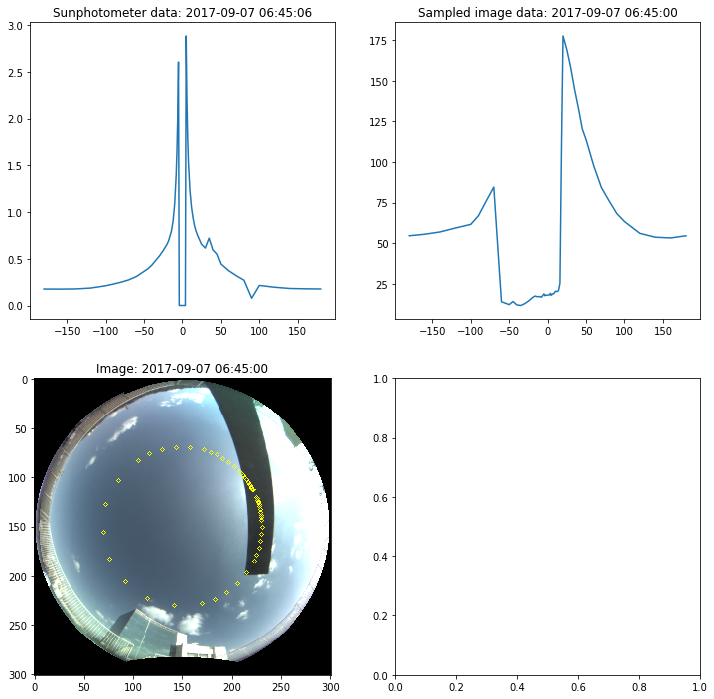

In [84]:
ch_index = 0
time_index = -6

angles, values, samples, img, closest_time, img_data = sampleData(
    spm_dfs,
    QEs,
    ch_index=ch_index,
    time_index=time_index,
    camera_df=camera_df
)

f, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
t = spm_dfs[ch_index].index[time_index]

axes[0, 0].plot(angles, values)
axes[0, 0].set_title('Sunphotometer data: {}'.format(t))
axes[0, 1].plot(angles, samples[:, 2-ch_index])
axes[0, 1].set_title('Sampled image data: {}'.format(closest_time))
axes[1, 0].imshow(np.clip((img/200), 0, 1)**0.6)
axes[1, 0].set_title('Image: {}'.format(closest_time))

### Fit the Models

In [166]:
time_index = -4
models = []
for ch_index, residual_threshold in tqdm(zip(range(3), (0.02, 0.02, 0.01)), leave=False):
    #
    # Capture image at specific channel.
    #
    angles, values, samples, img, closest_time, img_data = sampleData(
        spm_dfs,
        QEs,
        ch_index=ch_index,
        time_index=time_index,
        camera_df=camera_df
    )
    
    #
    # Define the model (1 order polynomial with ransac regressor).
    #
    model = make_pipeline(
        PolynomialFeatures(degree=1),
        RANSACRegressor(residual_threshold=residual_threshold)
    )
    
    #
    # Note that the samples are RGB but I pick only one channel.
    # The motivation is that the corresponding almacuntar measurements
    # span 3 minutes. So I prefer to take the nearest image (in time) per
    # channel.
    #
    model.fit(samples[:, ch_index].reshape((-1, 1)), values)
    models.append(model)

In [167]:
[m.steps[1][1].inlier_mask_.sum() for m in models]

[22, 20, 15]

### Check the fit on same time.

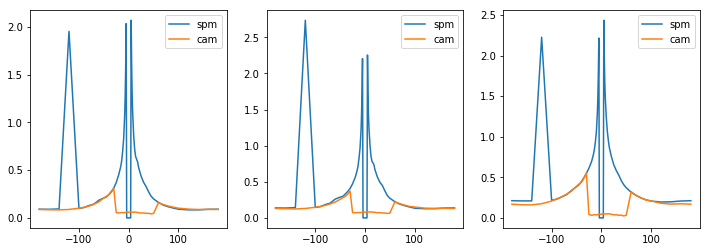

In [168]:
_, axes = plt.subplots(ncols=3, figsize=(12, 4))

for ch_index, ax in enumerate(axes.flatten()):
    #
    # Read the SunPhotometer values at specific time.
    #
    angles_blue, values_blue = readSunPhotoMeter(spm_dfs[0], spm_dfs[0].index[time_index])
    angles_green, values_green = readSunPhotoMeter(spm_dfs[1], spm_dfs[1].index[time_index])
    angles_red, values_red = readSunPhotoMeter(spm_dfs[2], spm_dfs[2].index[time_index])
    
    #
    # Join all datasets. This is important as not all datasets are sampled
    # at all angles. Therefore I use dropna() at the end.
    #
    blue_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[0]: values_blue}, index=angles_blue)
    green_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[1]: values_green}, index=angles_green)
    red_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[2]: values_red}, index=angles_red)
    SPM_df = pd.concat((blue_df, green_df, red_df), axis=1).dropna()

    angles, values = integrate_QE_SP(SPM_df, QEs[ch_index])
    
    ax.plot(angles, values, label="spm")
    ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape(-1, 1)), label="cam")
    ax.legend()

### Apply the Models to other Times

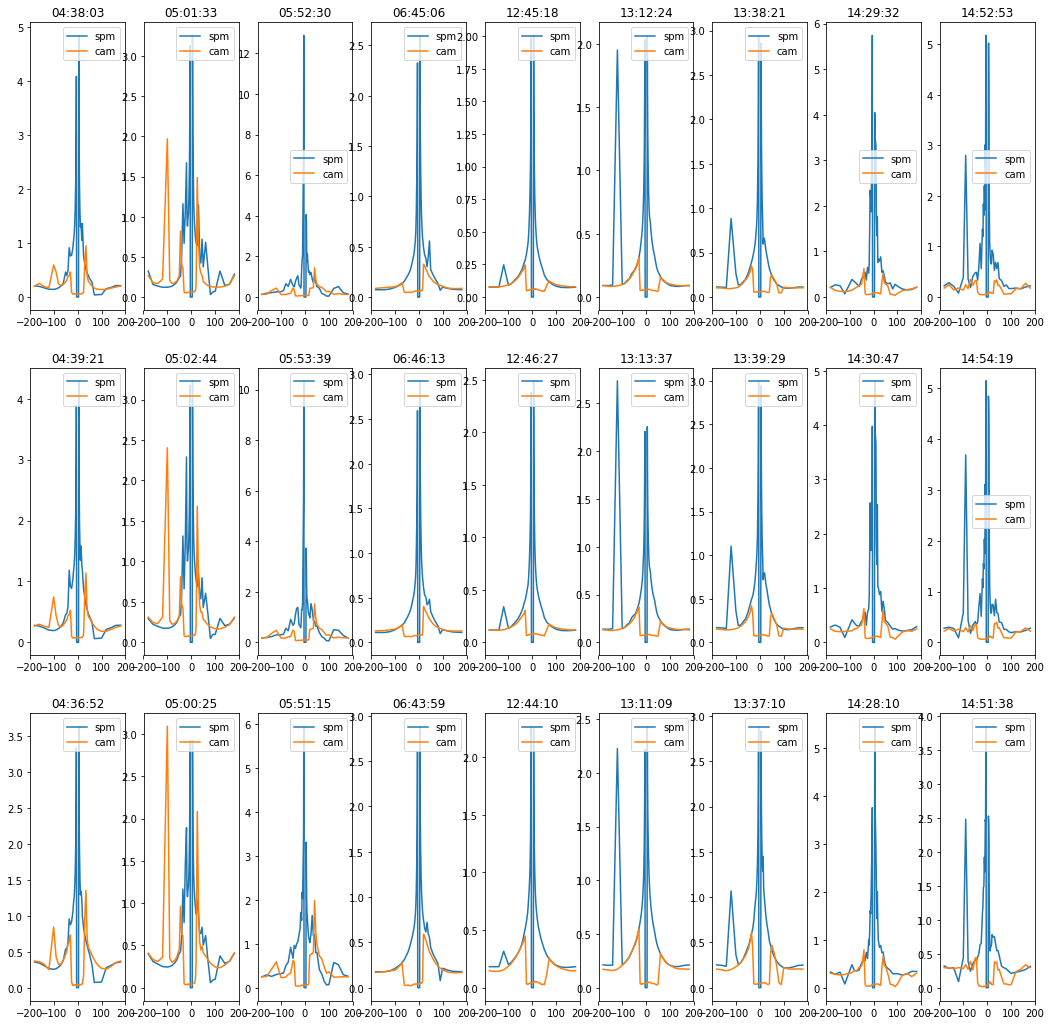

In [171]:
time_samples = spm_dfs[0].shape[0]
f, axes = plt.subplots(nrows=3, ncols=time_samples, figsize=(18, 18))

for time_index in tqdm(range(time_samples), leave=False):
    angles, values, samples, img, closest_time, img_data = sampleData(
        spm_dfs,
        QEs,
        ch_index=0,
        time_index=time_index,
        camera_df=camera_df
    )

    #
    # Note that contrary to when I do "fitting", here I take one image
    # for all the channels, as this is only for testing, and I neglect
    # the time it takes the sunphotometer to process all channels.
    # The motivation is to save the time of reading an image from the camera.
    #
    for ch_index, wl in enumerate(("Red", "Green", "Blue")):
        
        #
        # Read the SunPhotometer values at specific time.
        #
        angles_blue, values_blue = readSunPhotoMeter(spm_dfs[0], spm_dfs[0].index[time_index])
        angles_green, values_green = readSunPhotoMeter(spm_dfs[1], spm_dfs[1].index[time_index])
        angles_red, values_red = readSunPhotoMeter(spm_dfs[2], spm_dfs[2].index[time_index])

        #
        # Join all datasets. This is important as not all datasets are sampled
        # at all angles. Therefore I use dropna() at the end.
        #
        blue_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[0]: values_blue}, index=angles_blue)
        green_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[1]: values_green}, index=angles_green)
        red_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[2]: values_red}, index=angles_red)
        SPM_df = pd.concat((blue_df, green_df, red_df), axis=1).dropna()

        angles, values = integrate_QE_SP(SPM_df, QEs[ch_index])
        
        t = spm_dfs[ch_index].index[time_index]
        ax = axes[ch_index, time_index]
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

In [172]:
[m.steps[1][1].estimator_.coef_ for m in models]

[array([ 0.       ,  0.0025946]),
 array([ 0.        ,  0.00231467]),
 array([ 0.        ,  0.00342799])]

#### Save the Models

In [192]:
ratios = [model.steps[1][1].estimator_.coef_[1] for model in models]
with open("radiometric_{}.pkl".format(img_data.camera_info["serial_num"]), 'wb') as f:
    cPickle.dump(dict(ratios=ratios), f)

## Check on another day


                                     
100%|██████████| 9/9 [02:54<00:00, 19.31s/it]
                                             

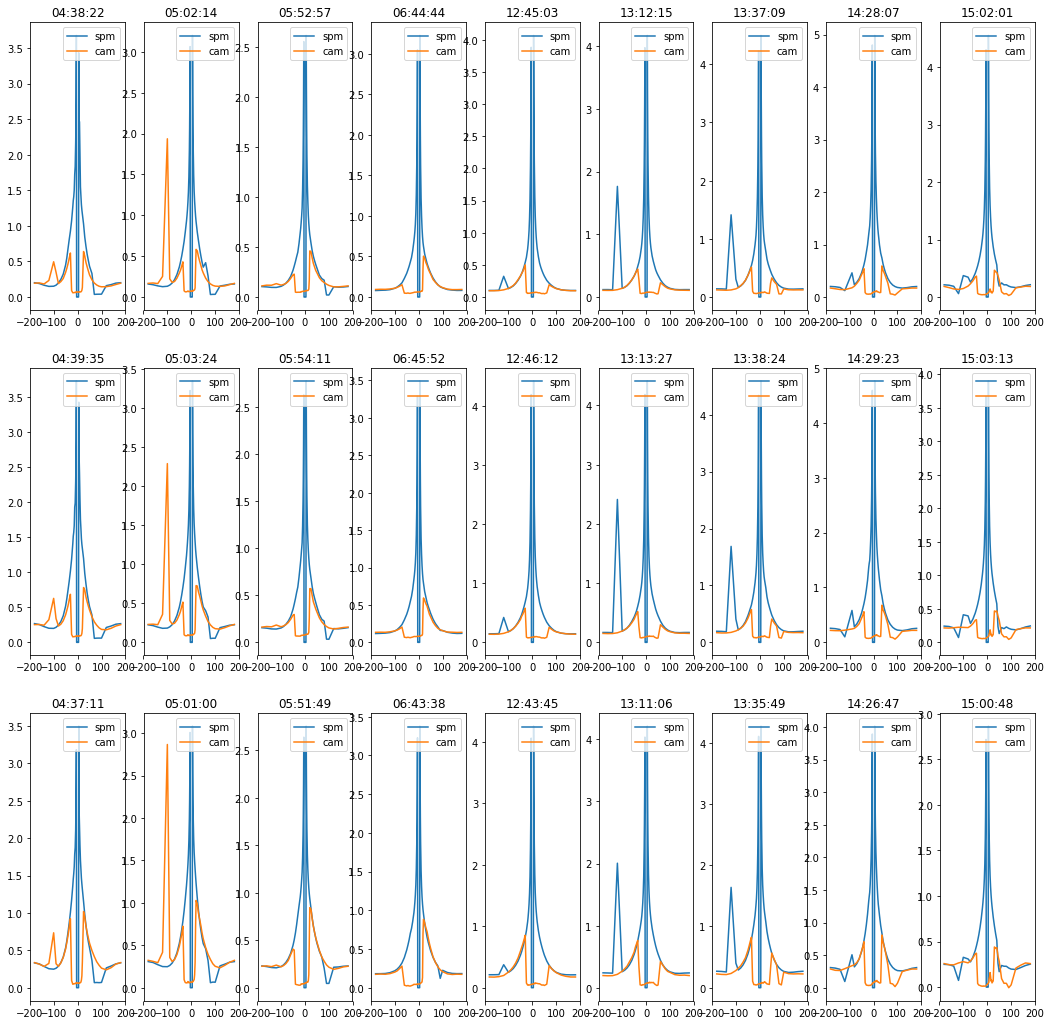

In [195]:
date = '2017-09-08'

spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
camera_df = cams.query(camera_id, date)[0]

f, axes = plt.subplots(nrows=3, ncols=time_samples, figsize=(18, 18))

time_samples = spm_dfs[0].shape[0]
for time_index in tqdm(range(time_samples), leave=False):
    angles, values, samples, img, closest_time, img_data = sampleData(
        spm_dfs,
        QEs,
        ch_index=0,
        time_index=time_index,
        camera_df=camera_df
    )

    #
    # Note that contrary to when I do "fitting", here I take one image
    # for all the channels, as this is only for testing, and I neglect
    # the time it takes the sunphotometer to process all channels.
    # The motivation is to save the time of reading an image from the camera.
    #
    for ch_index, wl in enumerate(("Red", "Green", "Blue")):
        
        #
        # Read the SunPhotometer values at specific time.
        #
        angles_blue, values_blue = readSunPhotoMeter(spm_dfs[0], spm_dfs[0].index[time_index])
        angles_green, values_green = readSunPhotoMeter(spm_dfs[1], spm_dfs[1].index[time_index])
        angles_red, values_red = readSunPhotoMeter(spm_dfs[2], spm_dfs[2].index[time_index])

        #
        # Join all datasets. This is important as not all datasets are sampled
        # at all angles. Therefore I use dropna() at the end.
        #
        blue_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[0]: values_blue}, index=angles_blue)
        green_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[1]: values_green}, index=angles_green)
        red_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[2]: values_red}, index=angles_red)
        SPM_df = pd.concat((blue_df, green_df, red_df), axis=1).dropna()

        angles, values = integrate_QE_SP(SPM_df, QEs[ch_index])
        
        t = spm_dfs[ch_index].index[time_index]
        ax = axes[ch_index, time_index]
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

## Check on another day another camera

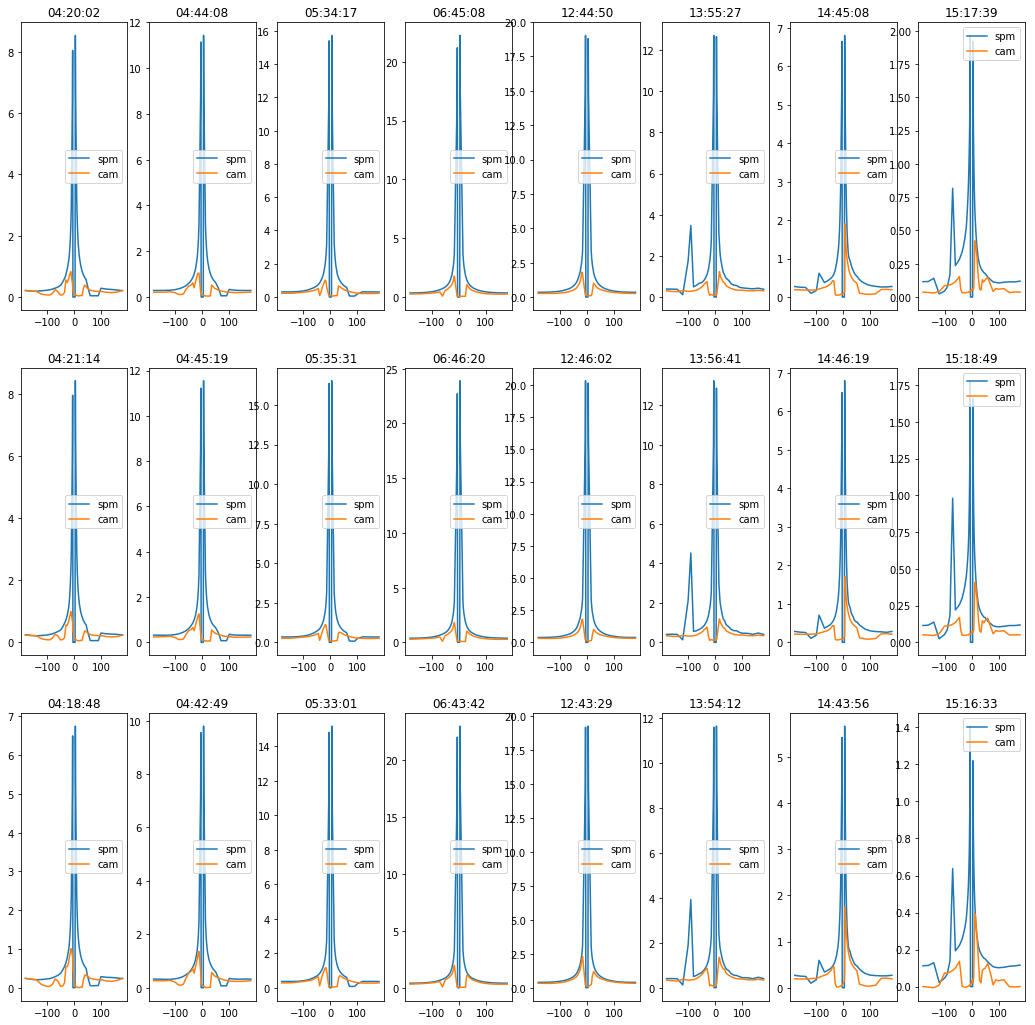

In [199]:
camera_id = 'cam_109bL'
date = '2017-04-26'

df = parseSunPhotoMeter(r'../../data/aeronet/2017_04/170401_170430_Technion_Haifa_IL.alm')
spm_dfs = [df[date][df[date]["Wavelength(um)"]==wl] for wl in SUNPHOTOMETER_WAVELENGTHS]
camera_df = cams.query(camera_id, date)[0]

f, axes = plt.subplots(nrows=3, ncols=time_samples, figsize=(18, 18))

time_samples = spm_dfs[0].shape[0]
for time_index in tqdm(range(time_samples), leave=False):
    angles, values, samples, img, closest_time, img_data = sampleData(
        spm_dfs,
        QEs,
        ch_index=0,
        time_index=time_index,
        camera_df=camera_df,
        cam_id=camera_id
    )

    #
    # Note that contrary to when I do "fitting", here I take one image
    # for all the channels, as this is only for testing, and I neglect
    # the time it takes the sunphotometer to process all channels.
    # The motivation is to save the time of reading an image from the camera.
    #
    for ch_index, wl in enumerate(("Red", "Green", "Blue")):
        
        #
        # Read the SunPhotometer values at specific time.
        #
        angles_blue, values_blue = readSunPhotoMeter(spm_dfs[0], spm_dfs[0].index[time_index])
        angles_green, values_green = readSunPhotoMeter(spm_dfs[1], spm_dfs[1].index[time_index])
        angles_red, values_red = readSunPhotoMeter(spm_dfs[2], spm_dfs[2].index[time_index])

        #
        # Join all datasets. This is important as not all datasets are sampled
        # at all angles. Therefore I use dropna() at the end.
        #
        blue_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[0]: values_blue}, index=angles_blue)
        green_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[1]: values_green}, index=angles_green)
        red_df = pd.DataFrame(data={SUNPHOTOMETER_WAVELENGTHS[2]: values_red}, index=angles_red)
        SPM_df = pd.concat((blue_df, green_df, red_df), axis=1).dropna()

        angles, values = integrate_QE_SP(SPM_df, QEs[ch_index])
        
        t = spm_dfs[ch_index].index[time_index]
        ax = axes[ch_index, time_index]
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[ch_index].predict(samples[:, ch_index].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

In [201]:
import pickle
with open("/VISL2_net/amitibo/experiment_2017_02-03/cam_109b/radiometric.pkl", "rb") as f:
    ratios = pickle.load(f)

In [202]:
ratios

{'ratios': [0.0025946043956850471,
  0.0023146700362069194,
  0.0034279864880272441]}

# Old Stuff

## Check on another day

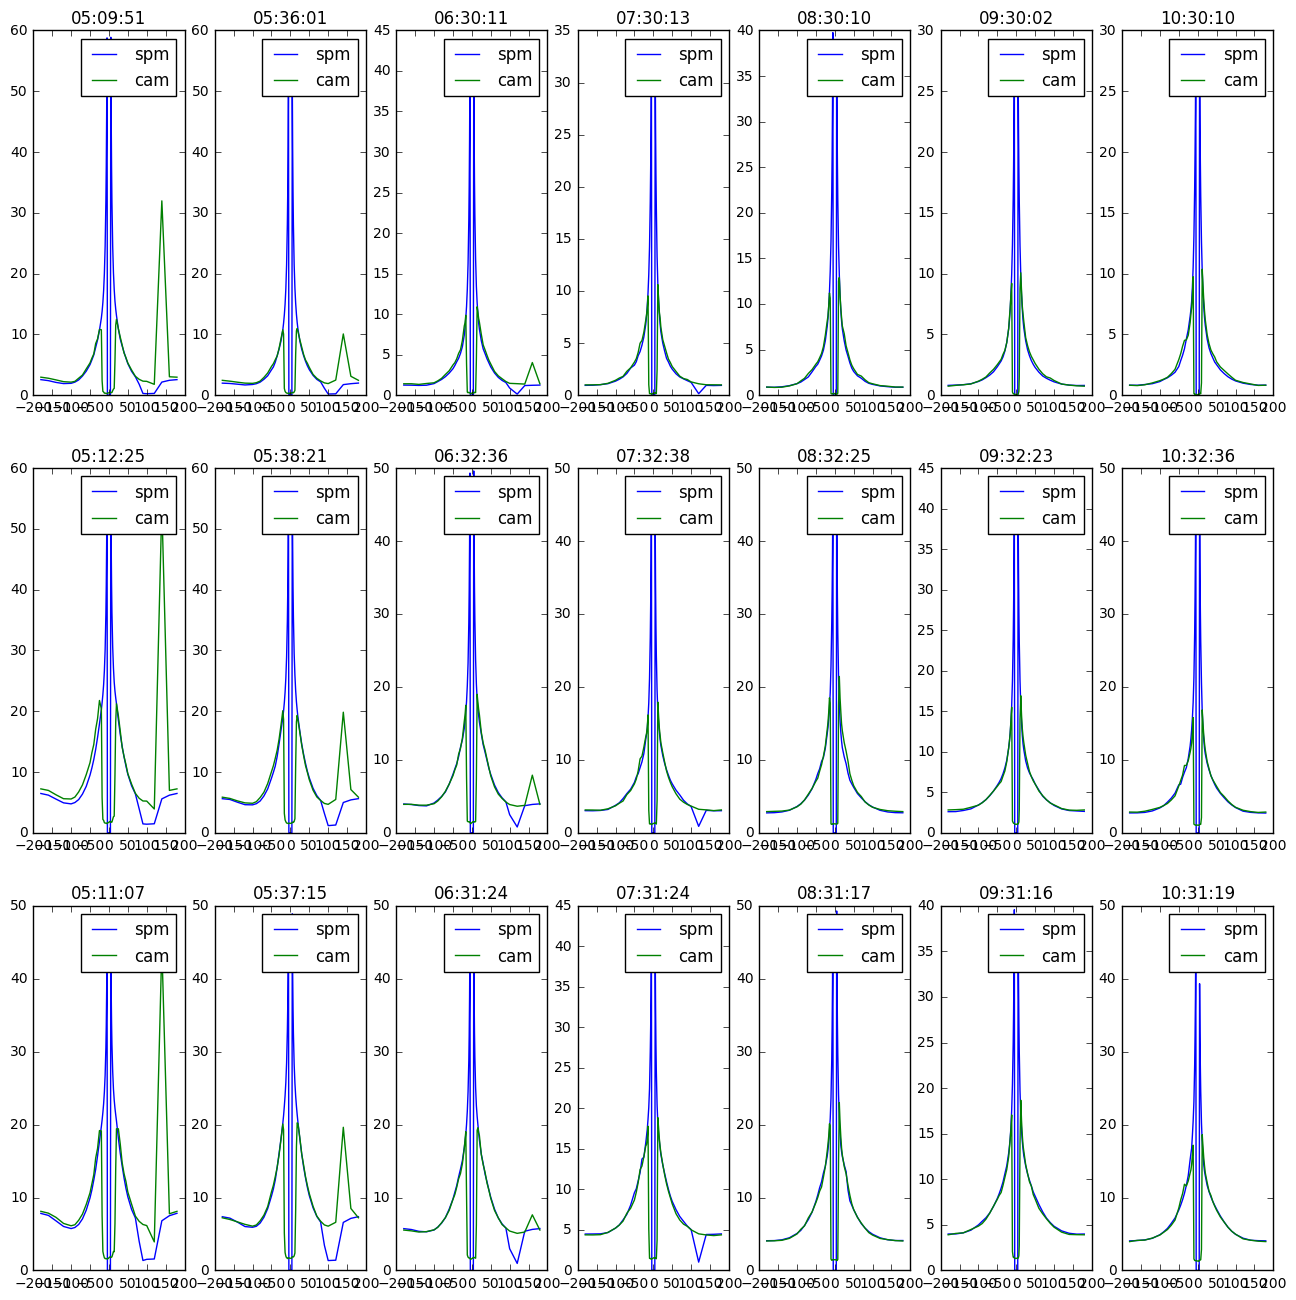

In [11]:
date = '2016-10-20'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

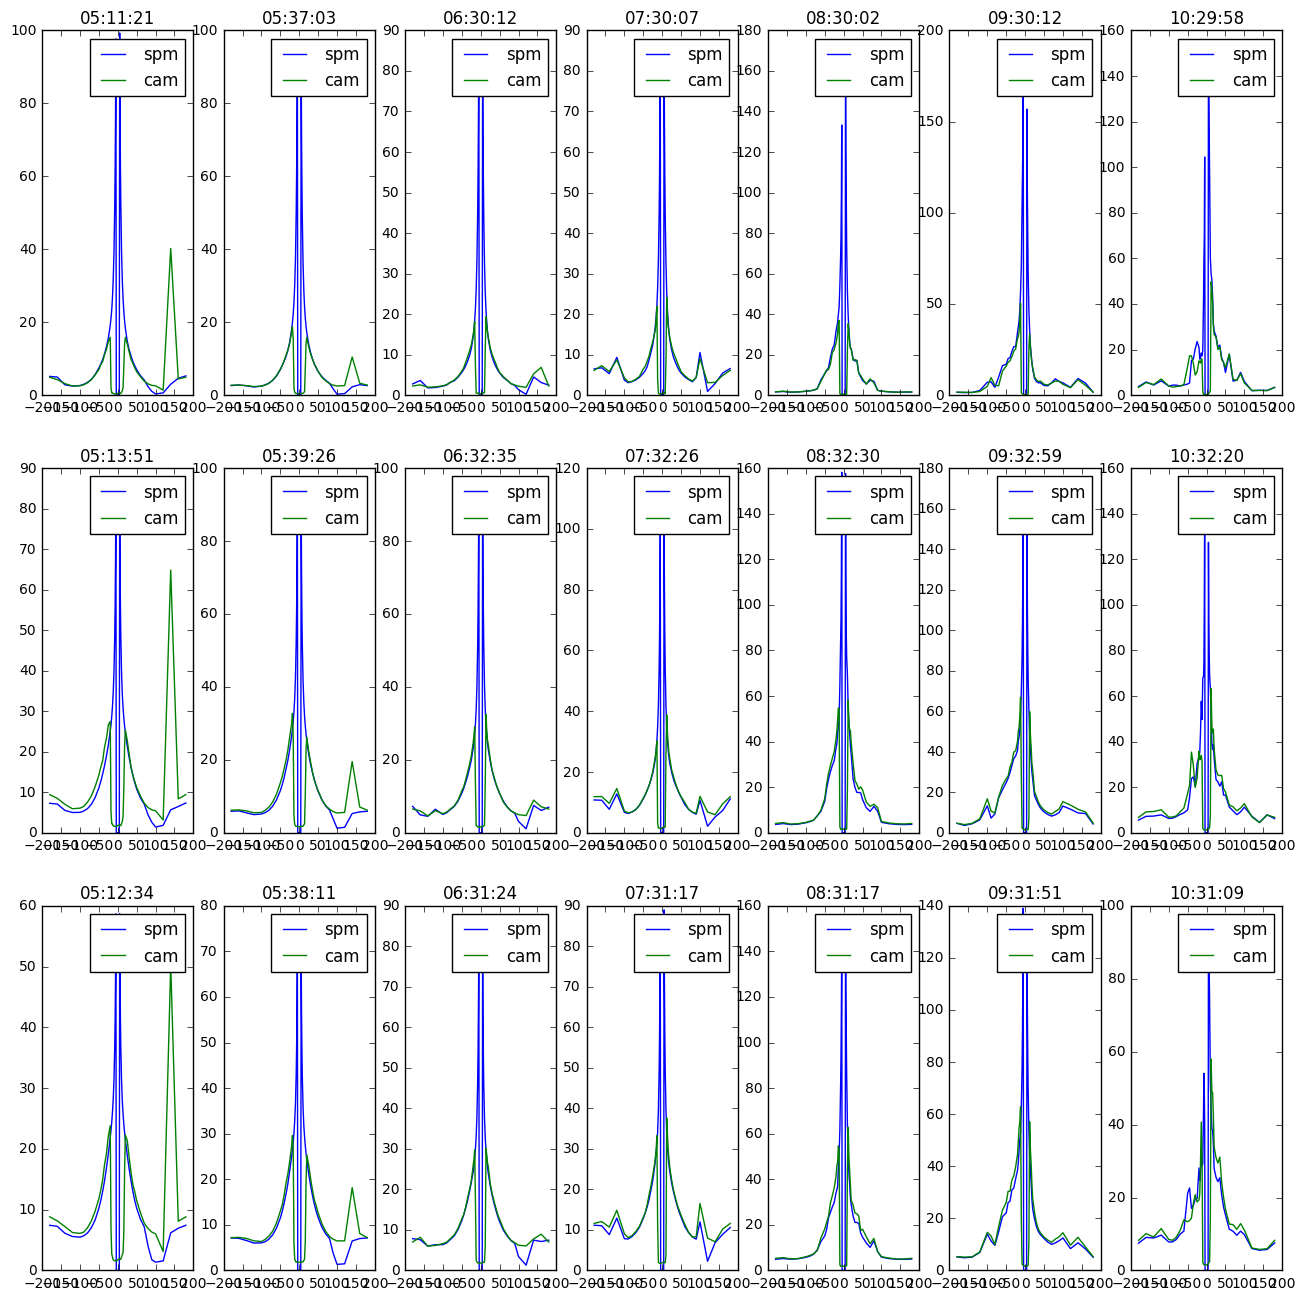

In [12]:
date = '2016-10-21'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

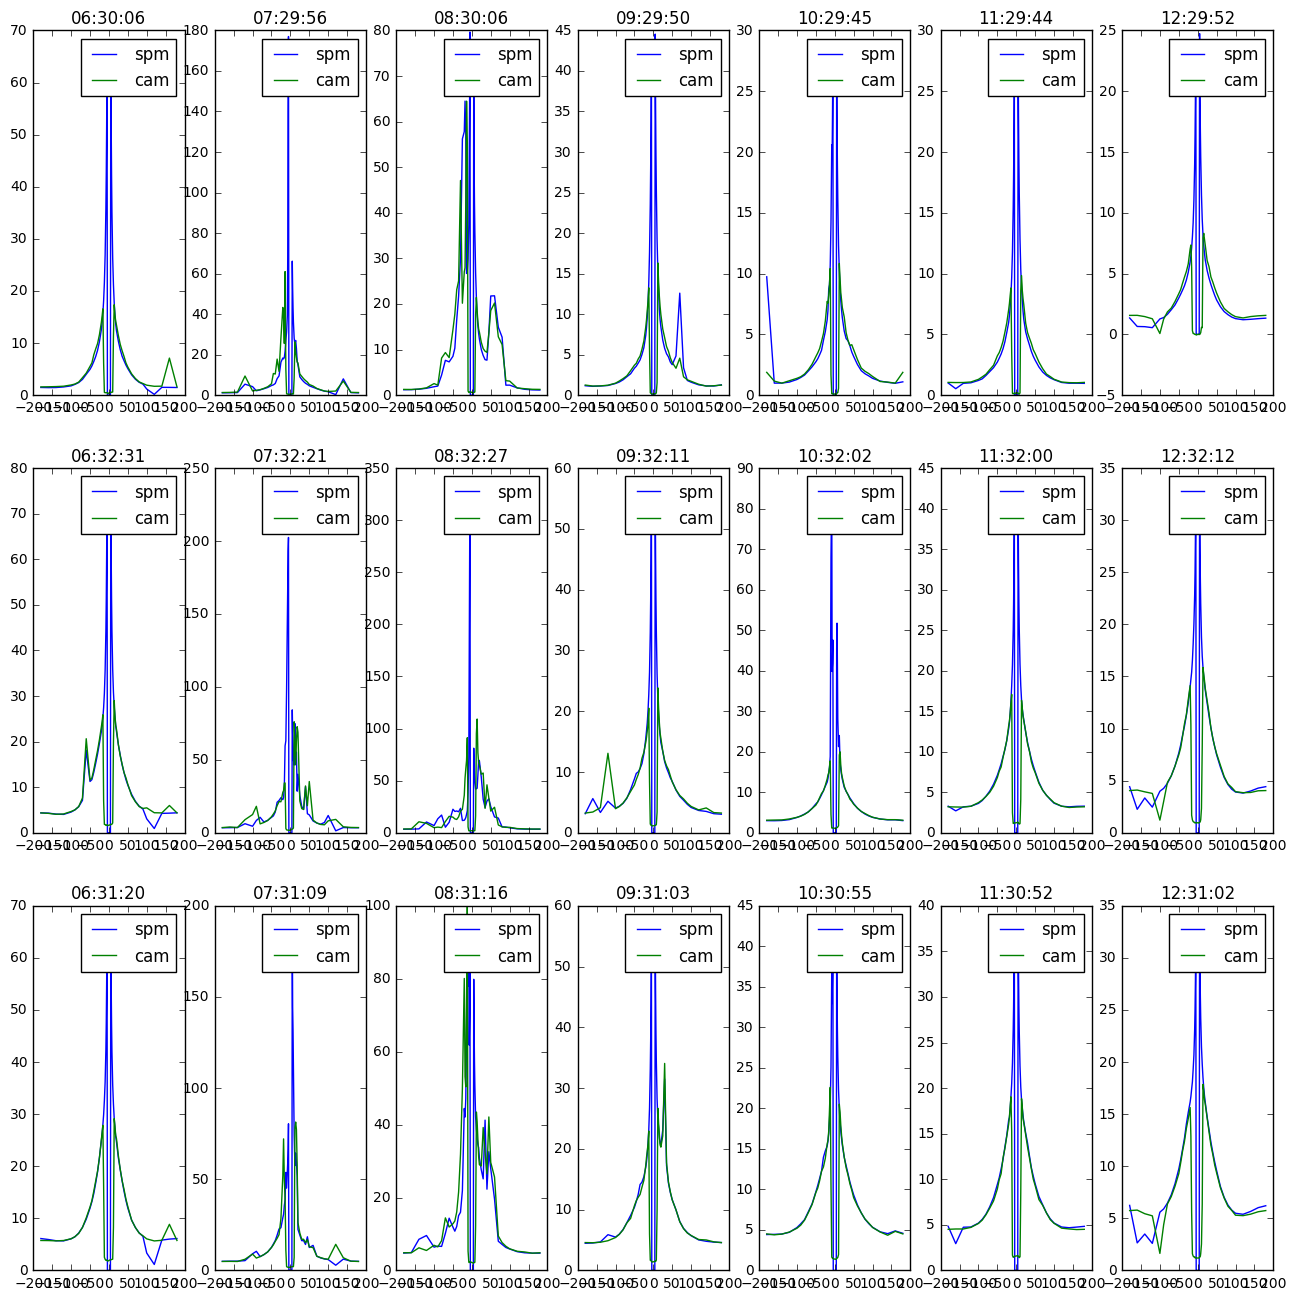

In [13]:
date = '2016-10-22'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

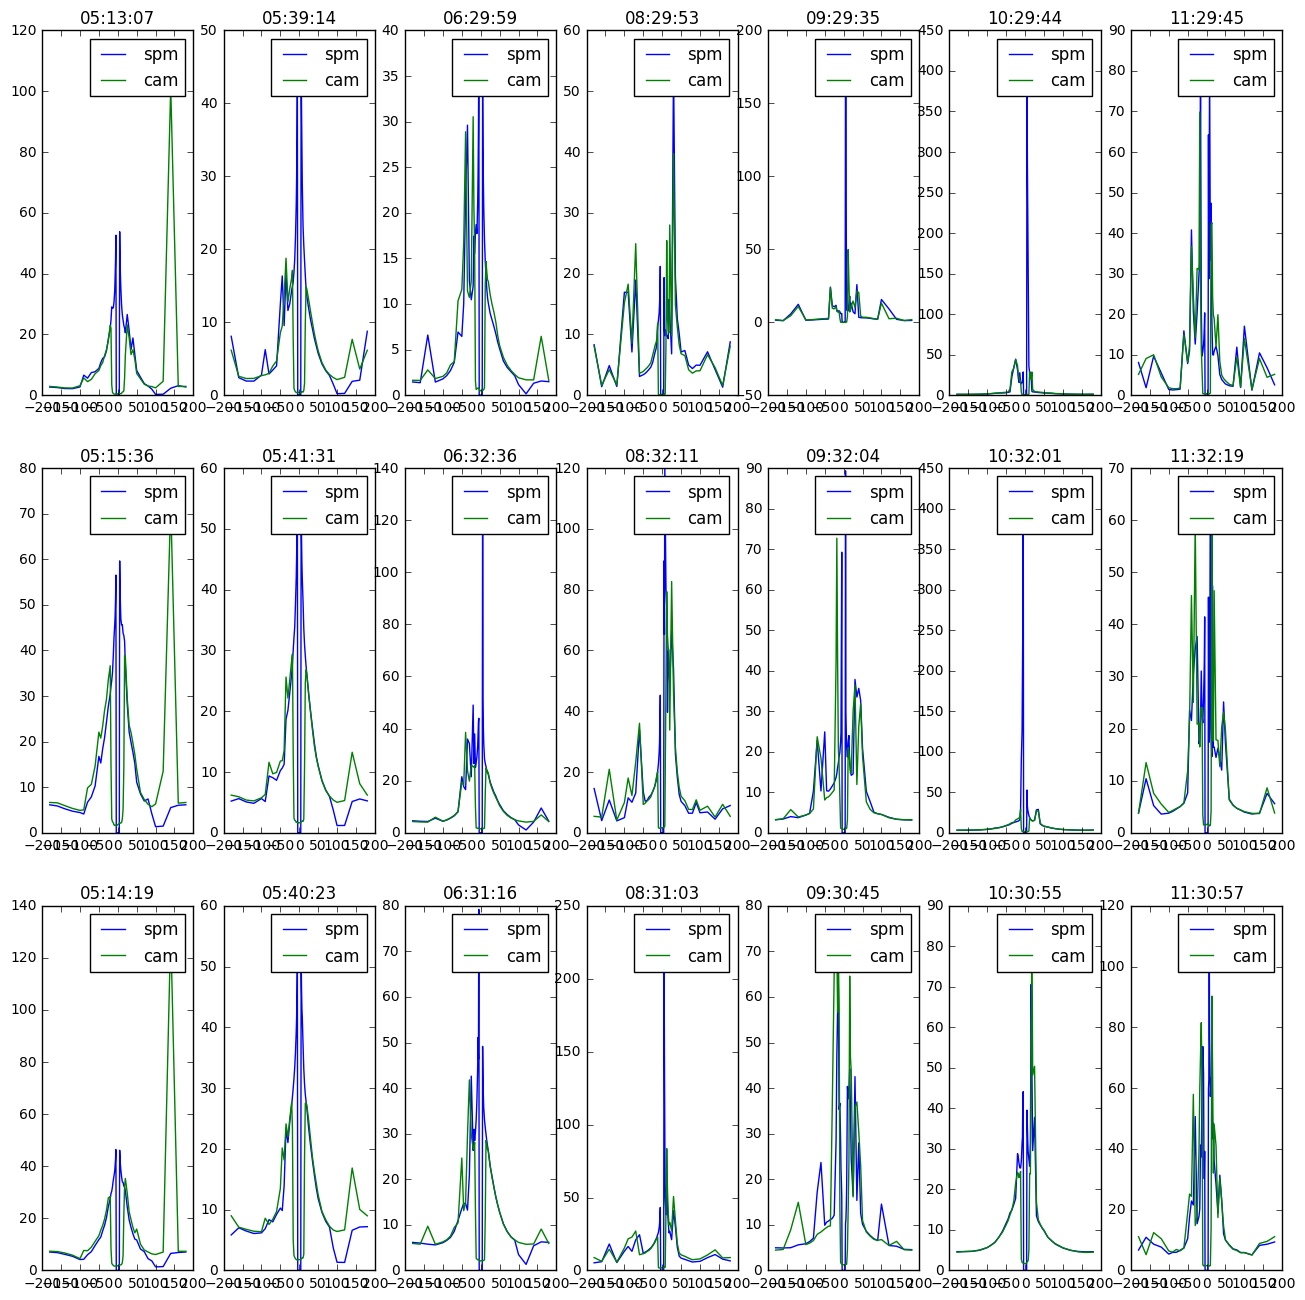

In [14]:
date = '2016-10-23'
spm_df = [df[date][df[date]["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]

qdf_102 = cams.query('102', date)

f, axes = plt.subplots(3, 7)
for i, wl in enumerate(("Red", "Green", "Blue")):
    for t, ax in zip(spm_df[i].index, axes[i, :].flatten()):
        angles, values, samples, img, closest_time, img_data = sampleData(spm_df[i], t, qdf_102)
        ax.plot(angles, values, label="spm")
        ax.plot(angles, models[i].predict(samples[:, i].reshape((-1, 1))), label="cam")
        ax.set_title("{}".format(t.time()))
        ax.legend()

## Compare to all cameras

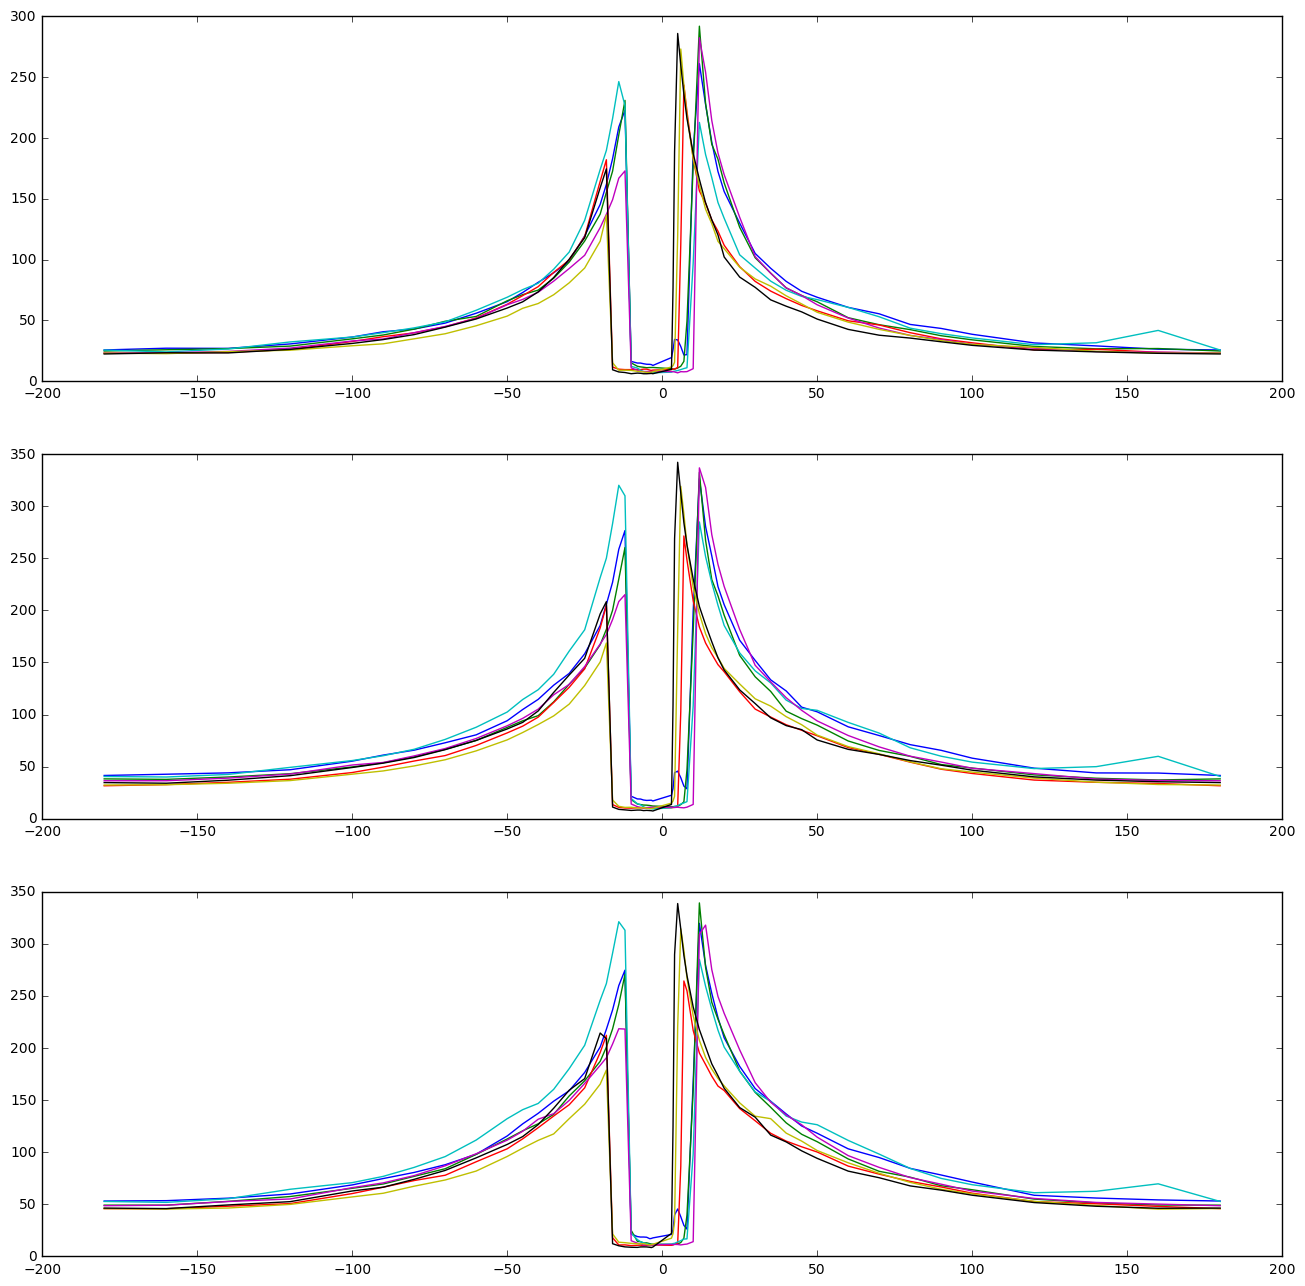

In [25]:
date = '2016-10-19'
f, axes = plt.subplots(3, 1)
t = spm_df[2].index[1]
cam_models = []
cam_samples = []
for i in range(1, 8):
    cam_id = '10{}'.format(i)
    cam_df = cams.query(cam_id, date)
    angles, _, samples, _, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)
    cam_samples.append(samples)
    for j in range(3):
        axes[j].plot(angles, samples[:, j])

## Fit all cameras to Cam 102 based on the Almucantar

In [26]:
date = '2016-10-19'
t = spm_df[2].index[3]
print t
cam_id = '102'
cam_df = cams.query(cam_id, date)
angles, _, samples_102, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)

def is_valid(X, y):
    return np.all((y > 20) & (y < 150))

cam_models = dict()
cam_samples = dict()
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    print(cam_id)
    cam_df = cams.query(cam_id, date)
    angles, _, samples, _, _ = sampleData(spm_df[2], t, cam_df, cam_id)
    models = []
    for j in range(3):
        model = make_pipeline(PolynomialFeatures(degree=1), RANSACRegressor(residual_threshold=5, max_trials=1000, is_data_valid=is_valid))
        model.fit(samples[:, j].reshape((-1, 1)), samples_102[:, j].reshape((-1, 1)))
        models.append(model)
    cam_models[cam_id] = models
    cam_samples[cam_id] = samples

2016-10-19 11:31:24
101
103
104
105
106
107


On the left is before fitting on the right after the fitting.

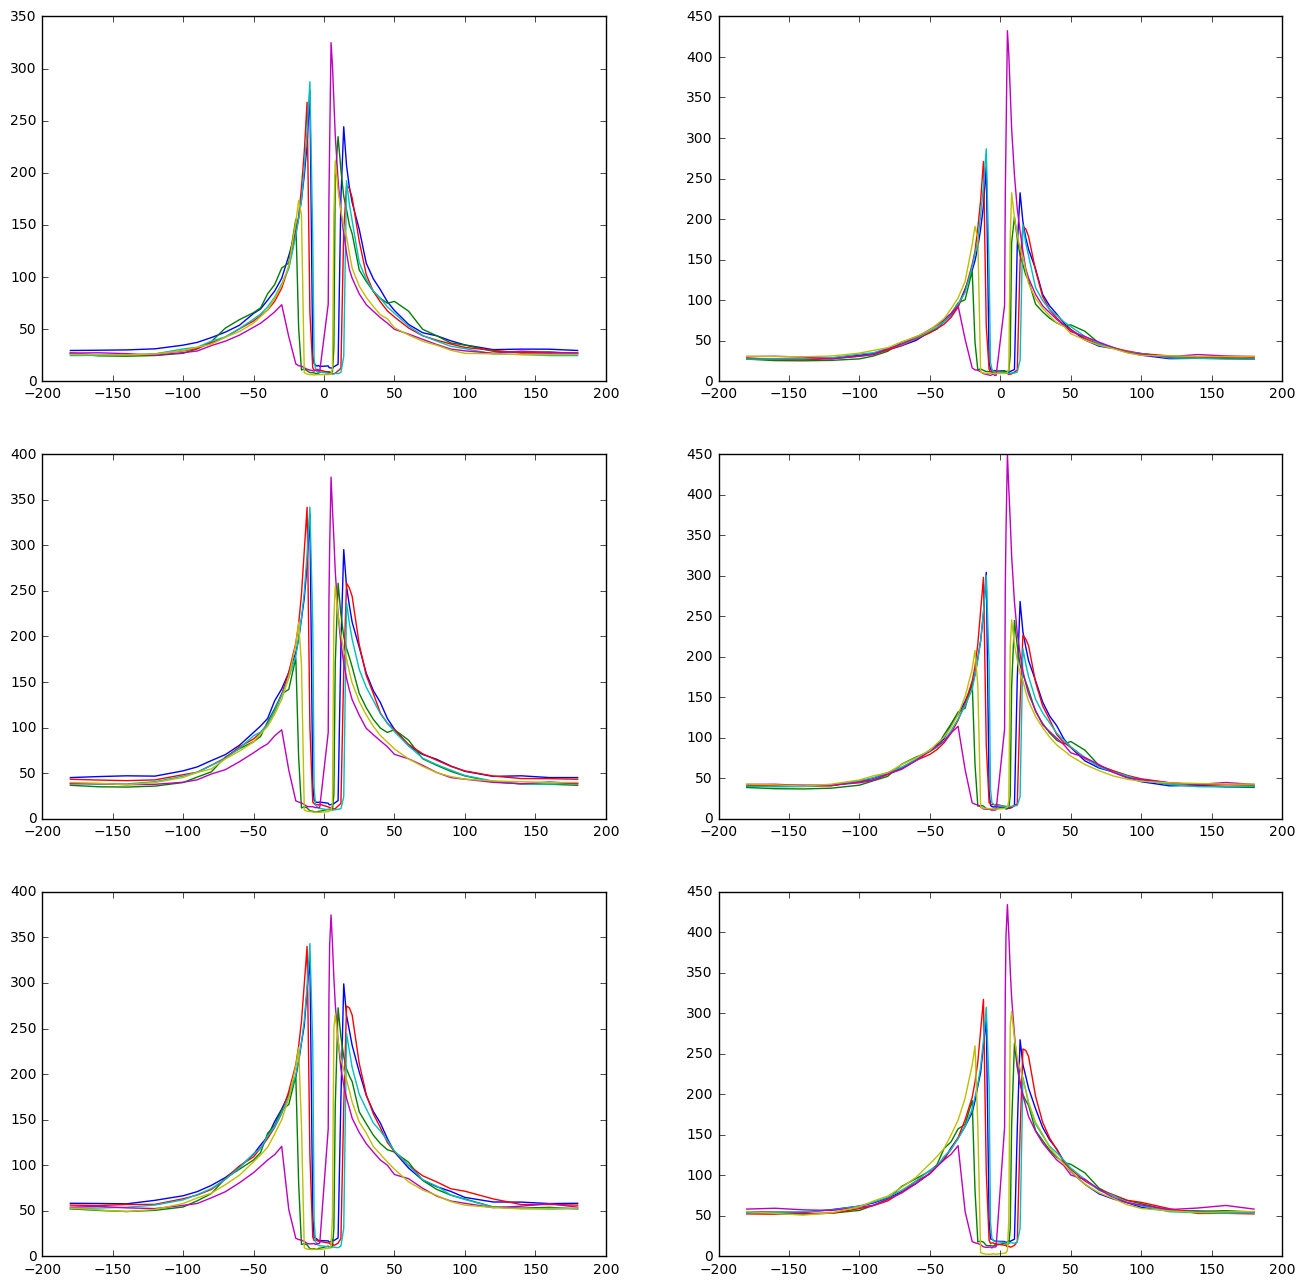

In [59]:
f, axes = plt.subplots(3, 2)
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    for j in range(3):
        models = cam_models[cam_id]
        samples = cam_samples[cam_id]
        tmp = models[j].predict(samples[:, j].reshape(-1, 1))
        axes[j, 0].plot(angles, cam_samples[cam_id][:, j])
        axes[j, 1].plot(angles, tmp)

## Ratio between each camera and camera 102 according to Almucantar

In [77]:
cam_ids, R, G, B = [], [], [], []
for i in (1, 3, 4, 5, 6, 7):
    cam_id = '10{}'.format(i)
    cam_ids.append(cam_id)
    R.append(cam_models[cam_id][0].steps[1][1].estimator_.coef_[0][1])
    G.append(cam_models[cam_id][1].steps[1][1].estimator_.coef_[0][1])
    B.append(cam_models[cam_id][2].steps[1][1].estimator_.coef_[0][1])
    
pd.DataFrame({'R':R, 'G': G, 'B': B}, index=cam_ids, columns=('R', 'G', 'B'))

,R,G,B
101,0.957016,0.914628,0.883177
103,0.843381,0.929400,0.943916
104,1.008111,0.859776,0.932540
105,0.987771,0.857663,0.872829
106,1.349310,1.211447,1.172096
107,1.087380,0.938838,1.162573


## Elbit results

Here we load Elbit calibration data that was calculated using the 'scripts_calibrate/analyze_elbit_measurements.py' script. This data is used to measure the radiometric response of each camera to camera 102.

In [27]:
CAM_MAP = {
    "4102820388": "cam_101",
    "4102820378": "cam_102",
    "4102820395": "cam_103",
    "4102820374": "cam_104",
    "4102820391": "cam_105",
    "4102820375": "cam_106",
    "4102820392": "cam_107",
}

with open('../../scripts_calibrate/elbit_results.pkl', 'rb') as f:
    data = cPickle.load(f)

cam_ids, R, G, B = [], [], [], []
for cam_id in sorted(CAM_MAP.values()):
    cam_ids.append(cam_id)
    cam_serial=list(CAM_MAP.keys())[list(CAM_MAP.values()).index(cam_id)]
    tmp = np.array(data["4102820378"])/np.array(data[cam_serial])
    R.append(tmp[0])
    G.append(tmp[1])
    B.append(tmp[2])

pd.DataFrame({'R':R, 'G': G, 'B': B}, index=cam_ids, columns=('R', 'G', 'B'))

,R,G,B
cam_101,1.051797,0.965710,1.005324
cam_102,1.000000,1.000000,1.000000
cam_103,0.966785,0.992743,0.979552
cam_104,0.961387,0.908698,0.941777
cam_105,1.108716,1.005257,1.056330
cam_106,1.115198,1.062346,1.079133
cam_107,1.198078,1.103405,1.130218


## Calculate Radiometric calibration for cameras

We use the sunphotometer to calibrate the camera 102. Then we use the elbit ratios to calibrate the rest of the cameras to 102 and the sunphotometer.

In [38]:
#
# Load the Elbit camera ratios.
#
with open("cam_102_sunphotometer_ratios.pkl", 'rb') as f:
    ratios = cPickle.load(f)

#
# Save calibration to home folders of the cameras.
#
base_path = r'D:\data\experiment_sukot_2016'
for cam_id in sorted(CAM_MAP.values()):
    cam_serial=list(CAM_MAP.keys())[list(CAM_MAP.values()).index(cam_id)]
    tmp = np.array(data["4102820378"])/np.array(data[cam_serial])
    with open(os.path.join(base_path, cam_id, '.radiometric.pkl'), 'wb') as f:
        cPickle.dump(dict(ratios=(tmp[0]*ratios[0], tmp[1]*ratios[1], tmp[2]*ratios[2])), f)

In [ ]:
cv2.WINDO